<a href="https://colab.research.google.com/github/Vaibhavi-Sita/PhishGuard/blob/main/COMP_517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

# ------------------------------
# Gemini LLM Setup
# ------------------------------
# Install SDK: pip install google-generativeai
# Read your API key (set as environment variable GEMINI_API_KEY)
import google.generativeai as genai

In [ ]:

# ------------------------------
# Load & Preprocess Dataset
# ------------------------------
df = pd.read_csv('./dataset_phishing.csv')

URL_COL   = 'url'

y = df['status']
X = df.drop('status', axis=1)

urls = df[URL_COL].values

# Split features and URLs together
X_train, X_test, y_train, y_test, urls_train, urls_test = train_test_split(
    X, y, urls, test_size=0.2, random_state=42
)


Logistic Regression with all features: {'accuracy': 0.47506561679790027, 'precision': 0.4746215494211932, 'recall': 0.4663167104111986, 'f1': 0.470432480141218, 'roc_auc': np.float64(0.47244438933322314)}


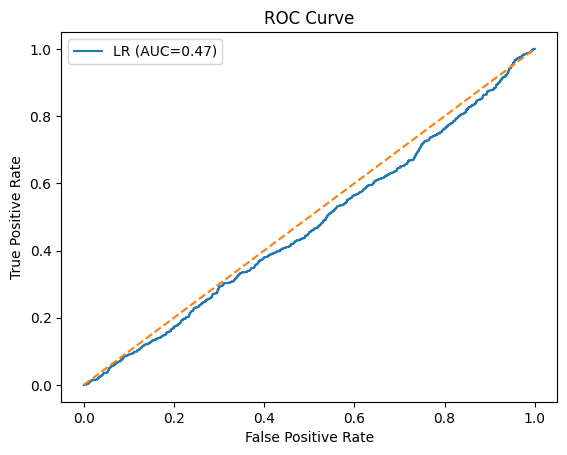

In [ ]:
# ------------------------------
# Heuristic Model: Logistic Regression
# ------------------------------

numeric_cols     = X_train.select_dtypes(include=[np.number]).columns.tolist()
text_col        = 'url'   # your raw URL column
categorical_cols = [c for c in X_train.columns
                    if c not in numeric_cols + [text_col]]

# 5. Build transformers & pipeline
preprocessor = ColumnTransformer([
    ('num',  StandardScaler(),            numeric_cols),
    ('txt',  TfidfVectorizer(analyzer='char_wb', ngram_range=(3,7), max_features=2000), text_cols),
    ('cat',  OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

clf = Pipeline([
    ('pre', preprocessor),
    ('lr',  LogisticRegression(max_iter=1000))
])

# 6. Train and evaluate
clf.fit(X_train, y_train)
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

# 8. Metrics
metrics = {
    'accuracy':  accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall':    recall_score(y_test, y_pred, zero_division=0),
    'f1':        f1_score(y_test, y_pred, zero_division=0),
    'roc_auc':   auc(*roc_curve(y_test, y_proba)[:2])
}
print("Logistic Regression with all features:", metrics)

# 9. (Optional) Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"LR (AUC={metrics['roc_auc']:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



Epoch 1 — Loss: 32.7026
Epoch 2 — Loss: 16.3176
Epoch 3 — Loss: 15.8389
Epoch 4 — Loss: 16.7745
Epoch 5 — Loss: 16.0432
URLNetMulti metrics: {'accuracy': 0.8035870516185477, 'precision': 0.9460154241645244, 'recall': 0.6439195100612424, 'f1': 0.7662675689744924, 'roc_auc': np.float64(0.774353610435616)}


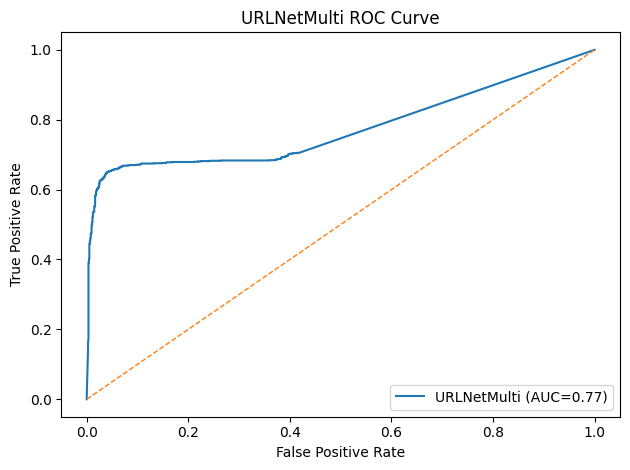

In [ ]:
# ------------------------------
# Deep Learning Model: URLNet
# ------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

URL_COL   = 'url'
LABEL_COL = 'status'

# If status is non‐numeric, map to 0/1
if not pd.api.types.is_numeric_dtype(df[LABEL_COL]):
    uniques = df[LABEL_COL].unique()
    label_map = {lab: i for i, lab in enumerate(sorted(uniques))}
    print("Label mapping:", label_map)
    df[LABEL_COL] = df[LABEL_COL].map(label_map)

# Ensure float dtype
df[LABEL_COL] = df[LABEL_COL].astype(float)

# ------------------------------
# 2) Prepare Features
# ------------------------------
# Numeric feature columns: all numeric except the label
numeric_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c != LABEL_COL
]

# URL → character sequence
max_len = 200
chars = sorted(set("".join(df[URL_COL])))
char2idx = {c: i+1 for i, c in enumerate(chars)}  # padding=0

def url_to_seq(u: str):
    seq = [char2idx.get(ch, 0) for ch in u[:max_len]]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    return seq

# Build arrays
seqs = np.vstack([url_to_seq(u) for u in df[URL_COL]])
X_num = df[numeric_cols].values
y     = df[LABEL_COL].values

# ------------------------------
# 3) Train / Test Split
# ------------------------------
seqs_train, seqs_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    seqs, X_num, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4) PyTorch Dataset + DataLoader
# ------------------------------
class URLNetDataset(Dataset):
    def __init__(self, seqs, nums, labels):
        self.seqs   = torch.LongTensor(seqs)
        self.nums   = torch.FloatTensor(nums)
        self.labels = torch.FloatTensor(labels)
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        return self.seqs[idx], self.nums[idx], self.labels[idx]

train_ds = URLNetDataset(seqs_train, X_num_train, y_train)
test_ds  = URLNetDataset(seqs_test,  X_num_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

# ------------------------------
# 5) Model Definition
# ------------------------------
class URLNetMulti(nn.Module):
    def __init__(self, vocab_size, num_feats, embed_dim=32, hidden_dim=128):
        super().__init__()
        # URL branch
        self.embedding = nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        conv_flat_dim = (max_len // 4) * 128

        # Numeric branch
        self.num_branch = nn.Sequential(
            nn.Linear(num_feats, hidden_dim),
            nn.ReLU()
        )

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(conv_flat_dim + hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, seqs, nums):
        # URL conv pipeline
        x = self.embedding(seqs)           # (B, L, E)
        x = x.permute(0, 2, 1)             # (B, E, L)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)          # (B, conv_flat_dim)

        # Numeric pipeline
        n = self.num_branch(nums)          # (B, hidden_dim)

        # Concatenate & classify
        combined = torch.cat([x, n], dim=1)
        return self.classifier(combined).squeeze()

# ------------------------------
# 6) Training Setup
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = URLNetMulti(vocab_size=len(char2idx),
                    num_feats=len(numeric_cols)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# ------------------------------
# 7) Training Loop
# ------------------------------
for epoch in range(1, 6):
    model.train()
    total_loss = 0.0
    for seqs_batch, nums_batch, labels_batch in train_loader:
        seqs_batch   = seqs_batch.to(device)
        nums_batch   = nums_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(seqs_batch, nums_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} — Loss: {avg_loss:.4f}")

# ------------------------------
# 8) Evaluation
# ------------------------------
model.eval()
all_probs, all_preds = [], []
with torch.no_grad():
    for seqs_batch, nums_batch, labels_batch in test_loader:
        seqs_batch = seqs_batch.to(device)
        nums_batch = nums_batch.to(device)
        probs = model(seqs_batch, nums_batch).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)

metrics = {
    'accuracy':  accuracy_score(y_test, all_preds),
    'precision': precision_score(y_test, all_preds, zero_division=0),
    'recall':    recall_score(y_test, all_preds, zero_division=0),
    'f1':        f1_score(y_test, all_preds, zero_division=0),
    'roc_auc':   auc(*roc_curve(y_test, all_probs)[:2])
}
print("URLNetMulti metrics:", metrics)

# ------------------------------
# 9) (Optional) ROC Curve Plot
# ------------------------------
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.plot(fpr, tpr, label=f'URLNetMulti (AUC={metrics["roc_auc"]:.2f})')
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("URLNetMulti ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# api_key = os.getenv("GEMINI_API_KEY")
api_key = ""

if not api_key:
    raise RuntimeError("Please set the GEMINI_API_KEY environment variable.")
genai.configure(api_key=api_key)

# Initialize the Gemini model
model = genai.GenerativeModel("gemini-2.0-flash")

def classify_with_gemini(url_list):
    """
    Classify URLs using Gemini.
    Prompt expects JSON: {"label":0 or 1, "confidence":0.00–1.00}
    """
    preds, probs = [], []
    for url in url_list:
        prompt = (
            "You are a cybersecurity expert. "
            "Classify this URL as 'phishing' (label=0) or 'safe' (label=1). "
            "Respond ONLY with JSON exactly like {\"label\":0,\"confidence\":0.00}. "
            f"URL: {url}"
        )
        response = model.generate_content(prompt)
        text = response.text.strip()
        try:
            result = json.loads(text)
            label = int(result.get("label", 1))
            confidence = float(result.get("confidence", 0.0))
        except (json.JSONDecodeError, ValueError, TypeError):
            label = 0 if "phishing" in text.lower() else 1
            confidence = 0.5
        preds.append(label)
        probs.append(confidence)
    return np.array(preds), np.array(probs)


In [ ]:
# ------------------------------
# Metrics & Visualization
# ------------------------------
def get_metrics(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": auc(*roc_curve(y_true, y_prob)[:2])
    }

metrics_lr = get_metrics(y_test, lr_preds, lr_probs)
metrics_gemini = get_metrics(y_test, gemini_preds, gemini_probs)
metrics_urlnet = get_metrics(y_test, urlnet_preds, urlnet_probs)

models = ["Logistic Regression", "Gemini", "URLNet"]
metrics_df = pd.DataFrame([metrics_lr, metrics_gemini, metrics_urlnet], index=models)

# Bar Chart
metrics_df[["accuracy", "precision", "recall", "f1"]].plot.bar()
plt.title("Model Comparison: Metrics")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure()
for name, probs in zip(models, [lr_probs, gemini_probs, urlnet_probs]):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
